In [1]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [2]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [3]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [4]:
# sub number
sub_num = 0

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 6s 61ms/step - loss: 0.5927 - accuracy: 0.7253 - val_loss: 0.5387 - val_accuracy: 0.7367
Epoch 2/200
98/99 [============================>.] - ETA: 0s - loss: 0.4554 - accuracy: 0.7663
Epoch 00002: val_loss improved from inf to 0.40304, saving model to best_model_1.h5
99/99 [==============================] - 5s 53ms/step - loss: 0.4548 - accuracy: 0.7665 - val_loss: 0.4030 - val_accuracy: 0.7937
Epoch 3/200
99/99 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.7953
Epoch 00003: val_loss did not improve from 0.40304
99/99 [==============================] - 5s 49ms/step - loss: 0.4115 - accuracy: 0.7953 - val_loss: 0.4490 - val_accuracy: 0.7918
Epoch 4/200
99/99 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8048
Epoch 00004: val_loss did not improve from 0.40304
99/99 [==============================] - 5s 54ms/step - loss: 0.4005 - accuracy: 0.8048 - val_loss: 0.4211 - val_accuracy: 0.78

Epoch 30/200
99/99 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9233
Epoch 00030: val_loss did not improve from 0.18156
99/99 [==============================] - 5s 51ms/step - loss: 0.2142 - accuracy: 0.9233 - val_loss: 0.1953 - val_accuracy: 0.9268
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9252
Epoch 00031: val_loss did not improve from 0.18156
99/99 [==============================] - 5s 53ms/step - loss: 0.2087 - accuracy: 0.9252 - val_loss: 0.2139 - val_accuracy: 0.9268
Epoch 32/200
98/99 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9292
Epoch 00032: val_loss did not improve from 0.18156
99/99 [==============================] - 5s 50ms/step - loss: 0.2003 - accuracy: 0.9281 - val_loss: 0.1908 - val_accuracy: 0.9268
Epoch 33/200
99/99 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9246
Epoch 00033: val_loss did not improve from 0.18156
99/99 [===============

Epoch 59/200
99/99 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9417
Epoch 00059: val_loss did not improve from 0.14642
99/99 [==============================] - 5s 53ms/step - loss: 0.1646 - accuracy: 0.9417 - val_loss: 0.2031 - val_accuracy: 0.9354
Epoch 60/200
99/99 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9328
Epoch 00060: val_loss did not improve from 0.14642
99/99 [==============================] - 5s 53ms/step - loss: 0.1717 - accuracy: 0.9328 - val_loss: 0.1488 - val_accuracy: 0.9420
Epoch 61/200
98/99 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9432
Epoch 00061: val_loss did not improve from 0.14642
99/99 [==============================] - 5s 53ms/step - loss: 0.1517 - accuracy: 0.9430 - val_loss: 0.1499 - val_accuracy: 0.9468
Epoch 62/200
99/99 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9344
Epoch 00062: val_loss did not improve from 0.14642
99/99 [===============

99/99 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9449
Epoch 00088: val_loss did not improve from 0.13112
99/99 [==============================] - 5s 51ms/step - loss: 0.1465 - accuracy: 0.9449 - val_loss: 0.1457 - val_accuracy: 0.9430
Epoch 89/200
98/99 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9464
Epoch 00089: val_loss did not improve from 0.13112
99/99 [==============================] - 5s 49ms/step - loss: 0.1440 - accuracy: 0.9468 - val_loss: 0.1650 - val_accuracy: 0.9411
Epoch 90/200
98/99 [============================>.] - ETA: 0s - loss: 0.1391 - accuracy: 0.9477
Epoch 00090: val_loss did not improve from 0.13112
99/99 [==============================] - 5s 51ms/step - loss: 0.1403 - accuracy: 0.9477 - val_loss: 0.1729 - val_accuracy: 0.9363
Epoch 91/200
99/99 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9446
Epoch 00091: val_loss did not improve from 0.13112
99/99 [============================

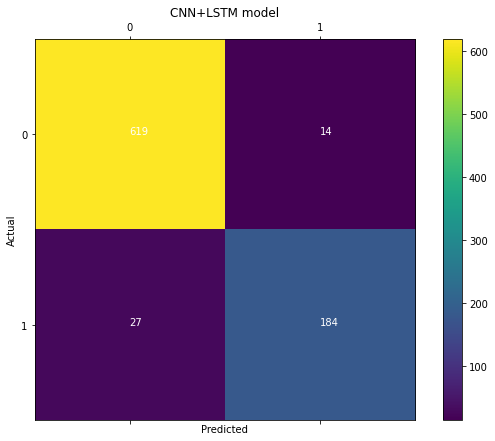

val_loss: 0.13111940026283264
test_loss: 0.14556917548179626
test_acc: 0.9514217972755432
precision: 0.9292929292929293
recall: 0.8720379146919431
specificity 0.9778830963665087
sensitivity :  0.8720379146919431
far 0.022116903633491312
frr 0.12796208530805686


In [5]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 41, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 67, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
# conv_3 = tf.keras.layers.Conv1D(filters = 43, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
# max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.7900385270299203)(max_2)
    
    
lstm_1 = tf.keras.layers.LSTM(27)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(117, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(32, activation = 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(31, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_3)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0006699313652483925), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0006699313652483925, momentum=0.4411297369087802), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])

# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)